# Practice on Monte Carlo Tree Search (MCTS)

Steps:
1. function <uct_policy>
2. function <expand>
After step 1 and 2, you can run <test_select_expand> section to assess your code. It should output the correct tree stucture.
1. function <rollout>


In [3]:
import numpy as np 
from scipy.special import softmax 
import time 

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 
import networkx as nx 

import sys 
sys.path.append("..") 
from utils.env import frozen_lake
from utils.viz import viz 
viz.get_style()

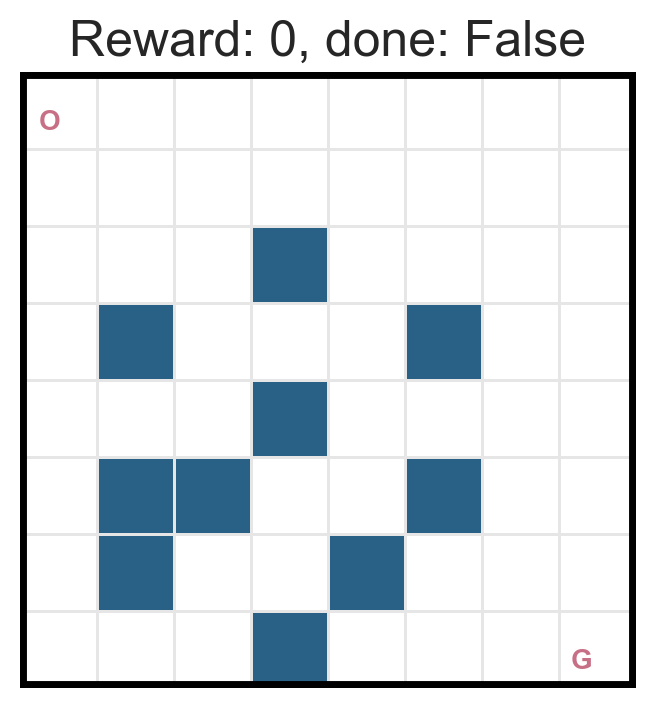

In [4]:
# The frozen lake 
layout = [
    "S.......",
    "........",
    "...H....",
    ".H...H..",
    "...H....",
    ".HH..H..",
    ".H..H...",
    "...H...G"
]
env = frozen_lake(layout)
env.reset()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
env.render(ax)

## MCTS: basic 

In [ ]:
# two types of nodes
class Node_s:
    type = 'state' # state nodes

    def __init__(self, s, parent=None):
        self.s = s
        self.n = 1 
        self.v = 0
        self.name = f's={s}'
        self.parent = parent
        if self.parent is not None:
            self.parent.children.append(self)
        self.children = []

class Node_a:
    type = 'action'

    def __init__(self, a, parent=None):
        self.a = a
        self.n = 1
        self.v = 0
        self.name = f'a={a}'
        self.parent = parent 
        if self.parent is not None:
            self.parent.children.append(self)
        self.children = []

## MCTS: select and expand

In [6]:
class MTCS:
    def __init__(self, model, c=1, rng=None):
        '''
        <model>: the environment object, e.g., env
        <c>: parameter to balance exploit and exploration. large c = largen tendency for exploration
        <rng>: the object to generate random samples and choices, set by e.g. rng = np.random.RandomState  (0)
        '''
        self.model = model 
        self.c     = c
        self.rng   = rng

    def plan(self, s, max_iter=100):
        '''Plan with MCTS
        <s>: int, the current state index,
        <max_iter>: int, the number of tree search
        '''
        root = Node_s(s)
        for _ in range(max_iter):
            node = self.select_expand(root)
            rew  = self.rollout(node)
            self.backprop(node, rew)
        return self.uct_policy(root, c=0), root
    

In [7]:
def viz_tree(node, deep=0):
    '''
    Visualize a tree structure
    '''
    key = node.name
    print('    |'*deep+'--'+key)
    for child in node.children:
        viz_tree(child, deep+1)

In [21]:
def select_expand(self, s_node):
    '''
    Input
    <s_node>: starting state node object

    Output
    We return the next state node object
    '''
    done = False
    while s_node.s not in self.model.s_termination:
        if self.fully_expanded(s_node):
            a = self.uct_policy(s_node, self.c)
            a_lst = [child.a for child in s_node.children]
            a_node = s_node.children[a_lst.index(a)]
        else:
            a = self.expand(s_node)
            a_node = Node_a(a, parent=s_node)
            s_node.children.append(a_node)
            done = True 
        # sample the next state 
        p_next = self.model.p_s_next(s_node.s, a)
        s_next = self.rng.choice(self.model.nS, p=p_next)
        s_next_lst = [child.s for child in a_node.children]
        if s_next in s_next_lst:
            s_next_node = a_node.children[s_next_lst.index(s_next)]
        else:
            s_next_node = Node_s(s_next, parent=a_node) 
            a_node.children.append(s_next_node)
        s_node = s_next_node
        if done: break  
    return s_node

def uct_policy(self, s_node, c=0):
    '''
    Given a state node object <s_node>, and exploration parameter <c>
    return an action according to uct_policy
    '''
    score = [] 
    a_lst = []
    for child in s_node.children: # loop all it's Children
        a_lst.append(child.a)
        exploit = (child.v / child.n) 
        explore = np.sqrt(2*np.log(child.parent.n) / child.n)
        score.append(exploit + c*explore)
    idx = self.rng.choice(np.where(score==np.max(score))[0].tolist())  
    return a_lst[idx] 

def expand(self, s_node):
        '''
        Given a state node object <s_node>, 
        return a previously unselected action in <s_node>
        '''
        a_selected = [child.a for child in s_node.children]
        a_unslected = set(list(range(self.model.nA)) - set(a_selected))
        a_unslected = list(a_unslected)
        a = self.rng.choice(a_unslected)
        return a 

def fully_expanded(self, s_node):
    return len(s_node.children) == self.model.nA

MTCS.select_expand = select_expand
MTCS.uct_policy = uct_policy
MTCS.expand = expand
MTCS.fully_expanded = fully_expanded

In [22]:
# check your answer in uct_policy and expand. 
def test_select_expand(self, s=0, max_iter=20):
    root = Node_s(s)
    for _ in range(max_iter):
        node = self.select_expand(root)
    viz_tree(root)

MTCS.test_select_expand = test_select_expand
rng = np.random.RandomState(0)
MTCS(env, rng=rng).test_select_expand(max_iter=10)

--s=0
    |--a=0
    |    |--s=0
    |    |    |--a=2
    |    |    |    |--s=0
    |    |    |--a=0
    |    |    |    |--s=0
    |    |    |--a=3
    |    |    |    |--s=1
    |--a=1
    |    |--s=8
    |--a=3
    |    |--s=1
    |--a=2
    |    |--s=0
    |    |    |--a=2
    |    |    |    |--s=0
    |    |    |--a=1
    |    |    |    |--s=8
    |    |    |--a=0
    |    |    |    |--s=0


In [23]:
def rollout(self, s_node):
    '''
    Given state node object <s_node>. We stats from s_node and run a simulation until reaching to an end
    '''
    s = s_node.s 
    r_sum = 0 
    done = False
    while True:
        a = self.rng.choice(self.model.nA)
        p_next = self.model.p_s_next(s, a)
        s_next = self.rng.choice(self.model.nS, p=p_next)
        r, done = self.model.r(s_next)
        r_sum += r
        if done: break
        s = s_next 
    return r_sum
MTCS.rollout = rollout

In [24]:
def backprop(self, node, r_sum):
    '''
    Given the final state node object in a rollout, we compute the accumulated reward and number of arrival
    '''
    while node is not None:
        node.n += 1
        node.v += r_sum
        node = node.parent
MTCS.backprop = backprop

In [25]:
def train(env, max_epi=1, seed=1234, max_iter=20):

    rng = np.random.RandomState(seed)
    agent = MTCS(model=env, c=1, rng=rng)
  
    for epi in range(max_epi):
        s, r, done = env.reset()
        t = 0 #
        G = 0 # what is G
        while True:
            # sample At, observe Rt, St+1
            a, root = agent.plan(s, max_iter=max_iter)
            s_next, r, done = env.step(a)
     
            t += 1
            G += r
            s = s_next

            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            clear_output(True)
            env.render(ax)
            time.sleep(.1)
            plt.show()
            
            if done:
                break 

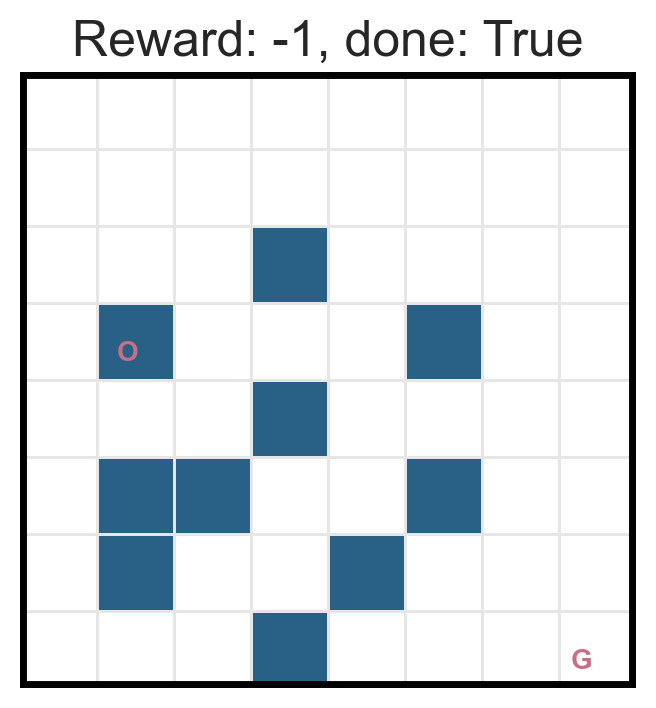

In [18]:
env = frozen_lake(layout=layout, eps=0)
train(env, seed=224, max_iter=20)

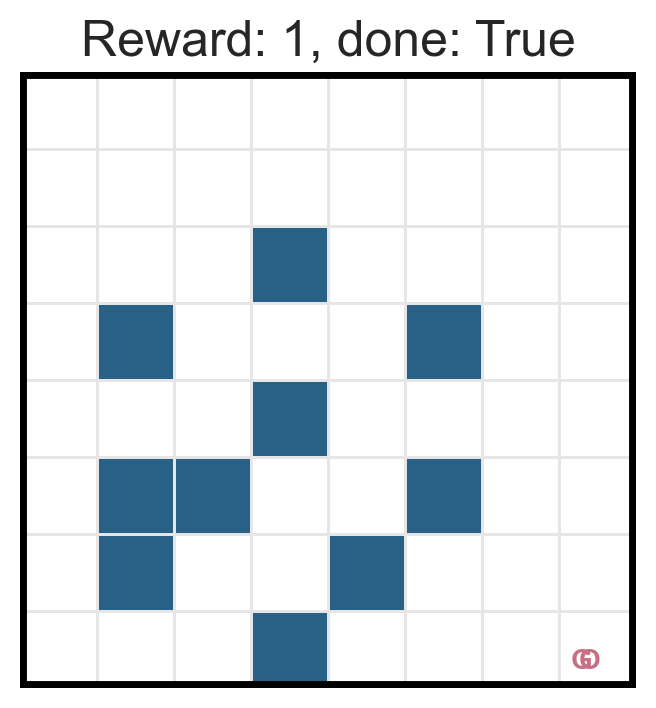

In [19]:
env = frozen_lake(layout=layout, eps=0)
train(env, seed=224, max_iter=200)

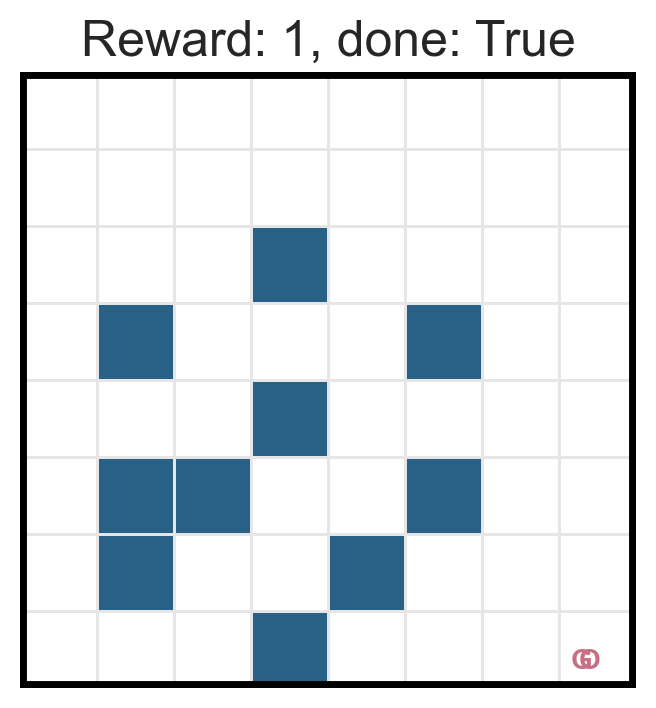

In [20]:
env = frozen_lake(layout=layout, eps=0)
train(env, seed=224, max_iter=1000)